In [39]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D,ZeroPadding1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv1D,UpSampling1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [95]:
#print(tf.__version__)

2.0.0-alpha0


In [ ]:
#!pip3 install gast==0.2.2

In [72]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = 'faces/'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [4]:
!ls

Music Generator.ipynb     faces                     midi-lstm-gan
Pokemon code tryout.ipynb image GANs.ipynb
face_images               maestro-v1.0.0


In [42]:
# Image set has 11,682 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_2.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading training images...")

    training_data = []
    faces_path = os.path.join(DATA_PATH,'temp_faces')
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path,filename)
        image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.


    print("Saving training image binary...")
    #np.save(training_binary_path,training_data)
    elapsed = time.time()-start
    print (f'Image preprocess time: {hms_string(elapsed)}')
else:
    print("Loading previous training pickle...")
    training_data = np.load(training_binary_path)

  0%|          | 0/3155 [00:00<?, ?it/s]

Looking for file: faces/training_data_96_96_2.npy
Loading training images...


100%|██████████| 3155/3155 [00:09<00:00, 328.69it/s]


Saving training image binary...
Image preprocess time: 0:00:10.22


In [43]:
faces_path = os.path.join(DATA_PATH,'temp_faces')
faces_path

'faces/temp_faces'

In [16]:
temp_face_1 = os.listdir(faces_path)[0]

In [17]:
temp_face_1

'rjobyr.9.jpg'

In [18]:
path = os.path.join(faces_path,temp_face_1)

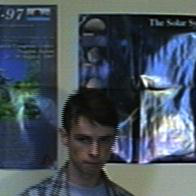

In [21]:
image = Image.open(path)
image

In [24]:
training_data

array([[[[-0.03529412,  0.05882359, -0.02745098],
         [-0.02745098,  0.06666672, -0.01960784],
         [-0.0745098 ,  0.01176476, -0.09019607],
         ...,
         [-0.01176471,  0.05098045, -0.12941176],
         [-0.05098039,  0.03529418, -0.05882353],
         [-0.05098039,  0.02745104, -0.05098039]],

        [[ 0.02745104,  0.11372554,  0.082353  ],
         [-0.00392157,  0.09019613,  0.04313731],
         [-0.02745098,  0.06666672,  0.01176476],
         ...,
         [-0.02745098,  0.03529418, -0.12156862],
         [-0.02745098,  0.04313731, -0.05098039],
         [-0.02745098,  0.04313731, -0.05098039]],

        [[-0.6       , -0.5137255 , -0.47450978],
         [-0.5372549 , -0.45098037, -0.41960782],
         [-0.46666664, -0.38039213, -0.3490196 ],
         ...,
         [-0.01960784,  0.02745104, -0.08235294],
         [-0.04313725,  0.01176476, -0.09019607],
         [-0.03529412,  0.02745104, -0.0745098 ]],

        ...,

        [[ 0.00392163,  0.16078436,  0

In [30]:
training_data.shape

(3155, 96, 96, 3)

In [28]:
training_data[0][1]

array([[ 0.02745104,  0.11372554,  0.082353  ],
       [-0.00392157,  0.09019613,  0.04313731],
       [-0.02745098,  0.06666672,  0.01176476],
       [-0.00392157,  0.09019613,  0.0196079 ],
       [-0.00392157,  0.09019613,  0.01176476],
       [ 0.00392163,  0.09803927,  0.00392163],
       [-0.01176471,  0.09019613, -0.01176471],
       [-0.01960784,  0.07450986, -0.02745098],
       [-0.01176471,  0.07450986, -0.03529412],
       [-0.02745098,  0.06666672, -0.05098039],
       [-0.03529412,  0.05098045, -0.05882353],
       [-0.03529412,  0.05882359, -0.05882353],
       [-0.02745098,  0.06666672, -0.04313725],
       [-0.01960784,  0.06666672, -0.04313725],
       [-0.01176471,  0.082353  , -0.03529412],
       [-0.01176471,  0.07450986, -0.02745098],
       [-0.01960784,  0.06666672, -0.02745098],
       [-0.01176471,  0.06666672, -0.01960784],
       [ 0.00392163,  0.07450986, -0.01960784],
       [-0.01176471,  0.05882359, -0.04313725],
       [-0.04313725,  0.02745104, -0.074

In [26]:
len(training_data[0][0])

3

In [11]:
training_data[0][0][0]

array([-0.03529412,  0.05882359, -0.02745098], dtype=float32)

# Midi data

In [31]:
!ls


All_Maestro_Parsed.npy      faces
Music Generator.ipynb       image GANs-Copy1.ipynb
Parse MIDI Files Test.ipynb image GANs.ipynb
Parse MIDI Files.ipynb      maestro-v1.0.0
Pokemon code tryout.ipynb   midi-lstm-gan
face_images


In [73]:
training_data_midi = np.load('All_Maestro_Parsed.npy')

In [74]:
training_data_midi.shape

(15300, 200, 3)

In [75]:
train_data_midi_temp = training_data_midi[:3000,:192,:]

In [76]:
train_data_midi_temp.shape

(3000, 192, 3)

In [77]:
training_data_midi[0].shape

(200, 3)

In [78]:
train_dataset_midi = tf.data.Dataset.from_tensor_slices(train_data_midi_temp) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [56]:
train_dataset_midi

<BatchDataset shapes: (None, 192, 3), types: tf.float64>

In [49]:
training_data_midi[0]

array([[1.81818182e-01, 8.45376135e-03, 0.00000000e+00],
       [2.61363636e-01, 9.27628948e-02, 1.71360027e-04],
       [1.70454545e-01, 1.23379220e-02, 7.19712115e-03],
       [1.25000000e-01, 5.94048095e-02, 7.19712115e-03],
       [1.81818182e-01, 6.07756897e-02, 5.27217684e-02],
       [2.72727273e-01, 2.09630434e-02, 1.73073628e-02],
       [2.50000000e-01, 2.23339236e-02, 1.57651225e-02],
       [2.61363636e-01, 9.82464157e-02, 1.97635232e-02],
       [1.70454545e-01, 7.59696122e-03, 7.31136117e-03],
       [1.25000000e-01, 5.85480094e-02, 8.22528132e-03],
       [1.81818182e-01, 6.32318501e-02, 5.12937682e-02],
       [2.72727273e-01, 2.51328040e-02, 2.16484835e-02],
       [2.50000000e-01, 1.81641629e-02, 1.79356829e-02],
       [2.61363636e-01, 2.62809162e-01, 1.58793625e-02],
       [1.70454545e-01, 1.02244816e-02, 7.31136117e-03],
       [1.25000000e-01, 3.90129662e-02, 8.79648141e-03],
       [1.81818182e-01, 2.05632033e-03, 4.03838465e-02],
       [1.81818182e-01, 4.16976

In [ ]:
path = os.path.join(faces_path,filename)
        image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [45]:
train_dataset

<BatchDataset shapes: (None, 96, 96, 3), types: tf.float32>

In [84]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*256,activation="relu",input_dim=SEED_SIZE))
    model.add(Reshape((4,256)))

    model.add(UpSampling1D())
    model.add(Conv1D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling1D())
    model.add(Conv1D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling1D())
    model.add(Conv1D(64,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling1D(size=(6)))
    model.add(Conv1D(32,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv1D(3,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    
    return model

    
    
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding1D(padding=((0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv1D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv1D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
for i in ge

In [8]:
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = generated_images[image_count] * 255
            image_count += 1

          
    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
  
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [88]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise, training=False)

#plt.imshow(generated_image[0, :, :, 0])

In [86]:
type(generator)

tensorflow.python.keras.engine.sequential.Sequential

In [89]:
image_shape = (192,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.502971]], shape=(1, 1), dtype=float32)


In [90]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [91]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [92]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    

        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return gen_loss,disc_loss

In [93]:
def train(dataset, epochs):
    #fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
    #                                   SEED_SIZE))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
        #save_images(epoch,fixed_seed)

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

In [15]:
#!pip3 install gast==0.2.2

In [94]:
train(train_dataset_midi, 20)

TypeError: Input 'filter' of 'Conv2D' Op has type float32 that does not match type float64 of argument 'input'.

In [17]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

In [29]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

NameError: name 'generator' is not defined